# <font color=green>GuruStock - A Comparative Study of Stock Price Prediction using Sentiment Analysis</font>

## **<font color=red>Sentiment Analysis of the Stocks</font>**

### Libraries and Modules

In [3]:
from textblob import TextBlob
import tweepy 
from tweepy import OAuthHandler
import os
import sys
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt

### Keys and Tokens for Twitter API

In [4]:
consumer_key = "vYnC9KnfWBn8glDIkLh0wu2Ew"
consumer_secret = "iUQHBV0GYS69Xoopz8LV6EGlEteTpTeTtw734S4HILMYS7EAWM"
access_token = "1084360003132125186-IisxCooPrfinEgPhlChrFuCSJDGUlF"
bearer_token = "AAAAAAAAAAAAAAAAAAAAANF4bQEAAAAAodBJIvocEsuKvR55%2FedDUkghF0U%3DOlEdqAculLBurvJI7A5zUeSMdzkfOgzMBqqUha4Bh45oEDPyyq"
access_token_secret = "DsxIfsPzqeZCl0oA51VZn5mNVPPDmpLC1lb5YcAJmgnA3"

### Authentication

In [5]:
try: 
    # create OAuthHandler object 
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
    # set access token and secret 
    auth.set_access_token(access_token, access_token_secret)
    # create tweepy API object to fetch tweets 
    api = tweepy.API(auth)
except: 
    print("Error: Authentication Failed")

### Fetching

In [6]:
query = input("Please enter a stock quote from the CSV to perform the search: ").upper()

# Checks if the sentiment for our quote is positive or negative
list_of_tweets = api.search_30_day(label = "Deve", query = query, maxResults= 100)
num_tweets = 100

Please enter a stock quote from the CSV to perform the search: ABNB


### Subjective Analysis

In [7]:
polarity = 0
positive = 0
negative = 0
neutral = 0
null = 0

flag = False

for tweet in list_of_tweets:
    analysis = TextBlob(tweet.text)
   #print(analysis)
    polarity = analysis.sentiment.polarity
   #print(polarity)
    if analysis.subjectivity == 0:  
        null += 1
        next
    if polarity < 0:
        negative += 1
    elif polarity == 0:
        neutral += 1
    else:
        positive += 1
        
if positive > ((num_tweets - null)/2):
    flag = True
    
if not flag:
    print('This stock has bad sentiment, please re-run the script')
    sys.exit()
else:
    print('This stock has good sentiment')

This stock has good sentiment


###  Visualization

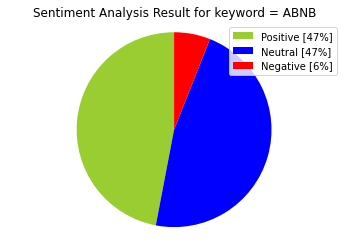

In [8]:
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword = "+query)
plt.axis('equal')
plt.show()

## <font color=red>**Fetching previous data using Yfinance**</font>

### Modules and Libraries

In [9]:
import yfinance as yf

### Fetching the Dataset 

In [10]:
if yf.Ticker(query) != 400:
    value = yf.Ticker(query)
    hist = value.history(period="5y")
    hist.to_csv('hist.csv')
else:
    raise RuntimeError('Connection Failed')
    
df = pd.read_csv('hist.csv')

## <font color = red>**The Linear Regression Model**</font> 

### Modules and Libraries

In [11]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

### Preprocessing the Dataset

In [12]:
df3 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df3 = scaler.fit_transform(np.array(df3).reshape(-1,1))

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

### Train-Test Split

In [13]:
training_size=int(len(df3)*0.65)
test_size=len(df3)-training_size

train_data,test_data=df3[0:training_size,:],df3[training_size:len(df3),:1]

time_step = 100
X_train1, y_train1 = create_dataset(train_data, time_step)
X_test1, y_test1 = create_dataset(test_data, time_step)

### Fitting the model

In [14]:
model3 = LinearRegression()
model3.fit(X_train1,y_train1)

LinearRegression()

### Predicting and Reverse transforming

In [26]:
y_pred = model3.predict(X_test1)
y_pred = y_pred.reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)


valFinal = y_pred[len(y_pred) - 1]
train_predict = model3.predict(X_train1)
train_predict = train_predict.reshape(-1,1)
train_predict=scaler.inverse_transform(train_predict)
val = train_predict[len(train_predict) - 1]

### Performance Analysis

In [27]:
print("RMS error when using Linear Regression on training data: ",math.sqrt(mean_squared_error(y_train1, train_predict)))
print("RMS error when using Linear Regression on testing data: ",math.sqrt(mean_squared_error(y_test1, y_pred)))

RMS error when using Linear Regression on training data:  156.3775451430755
RMS error when using Linear Regression on testing data:  109.86663277452695


### Visualization

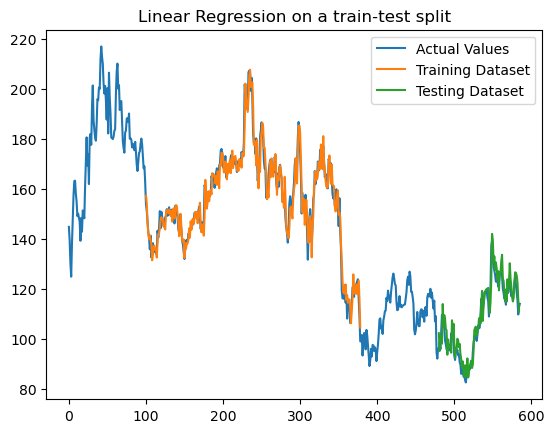

In [28]:
look_back=100
trainPredictPlot = np.empty_like(df3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

test_predict = y_pred
testPredictPlot = np.empty_like(df3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df3)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df3))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("Linear Regression on a train-test split")
plt.legend(labels)
plt.show()

### Final Verdict via Linear Regression

In [29]:
# Our prediction of the stock price from last training timestamp to last tested timestamp
print("The price will move from", (str(val)[1:-1]),"to" , str(valFinal)[1:-1])

The price will move from 104.44445529 to 110.90649086


## <font color=red>**The Random Forest Regressor Model**</font>

### Modules and Libraries

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Preprocessing the Dataset

In [21]:
df2 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

### Train-Test Split

In [22]:
training_size=int(len(df2)*0.65)
test_size=len(df2)-training_size

train_data,test_data=df2[0:training_size,:],df2[training_size:len(df2),:1]
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])

### Hyperparameter Tuning

In [23]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 5500, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8, 16]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Randomized K-fold Fitting

In [24]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 19, 28, 37, 46, 55,
                                                      64, 73, 82, 91, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 8, 16],
                                        'min_samples_split': [2, 4, 5, 10, 20],
                                        'n_estimators': [500, 550, 601, 651,
                                                         702, 752, 803, 853,
                                                         904, 954, 1005, 1055,
                                                         1106, 1156, 1207, 1257,
                                                         1308, 1358, 1409,

### Best Parameters and Performance Evaluation

In [25]:
best_parameters = rf_random.best_params_
print(best_parameters)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))   
    return accuracy

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

{'n_estimators': 5045, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
Model Performance
Average Error: 0.0931 degrees.
Accuracy = -inf%.


C:\Users\Vaibhav Kanojia\AppData\Local\Temp\ipykernel_12764\2973408551.py:7: RuntimeWarning: divide by zero encountered in true_divide
  mape = 100 * np.mean(errors / test_labels)


<font color=blue>{'n_estimators': 3530, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}</font>

### Predicting and Reverse transforming

In [30]:
train_predict=best_random.predict(X_train)
train_predict=train_predict.reshape(-1, 1)
train_predict = scaler.inverse_transform(train_predict)
array_length = len(train_predict)
val = train_predict[array_length - 1]

test_predict=best_random.predict(X_test)
test_predict=test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
array_length = len(test_predict)
val_test = test_predict[array_length - 1]

print("RMS error when using Random Forest Regression on training data: ",math.sqrt(mean_squared_error(y_train, train_predict)))
print("RMS error when using Random Forest Regression on testing data: ",math.sqrt(mean_squared_error(y_test, test_predict)))

RMS error when using Random Forest Regression on training data:  156.35998678905284
RMS error when using Random Forest Regression on testing data:  115.76770809576931


### Visualization

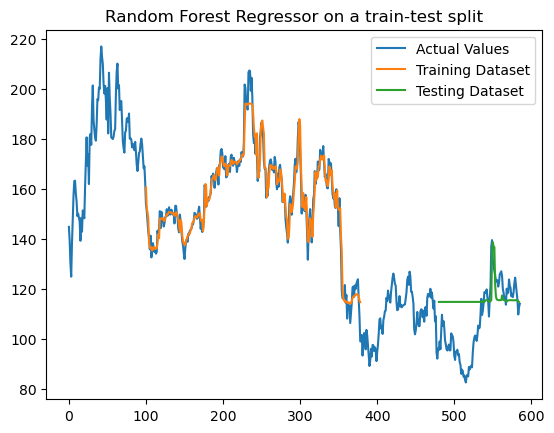

In [31]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("Random Forest Regressor on a train-test split")
plt.legend(labels)
plt.show()

### Final Verdict via Random Forest Regressor

In [32]:
# Our prediction of the stock price from last training timestamp to last tested timestamp
print("The price will move from", (str(val)[1:-1]),"to" , str(valFinal)[1:-1])

The price will move from 114.59380402 to 110.90649086


## <font color=red>**The LSTM model**</font>

### Modules and Libraries - LSTM

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Preprocessing the Dataset

In [25]:
df1 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))  

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY) 

### Train-Test Split

In [26]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size

train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Layers in the LSTM Model

In [27]:
# Creating a Multilinear Perceptron model
model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))  

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units=1))   

### Compiling, Fitting and Saving

In [28]:
optimizer = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test, y_test))

model.save('Final_model_lstm.h5')

Epoch 1/100
18/18 - 9s - loss: 0.0774 - val_loss: 0.0237 - 9s/epoch - 501ms/step
Epoch 2/100
18/18 - 2s - loss: 0.0202 - val_loss: 0.0247 - 2s/epoch - 116ms/step
Epoch 3/100
18/18 - 2s - loss: 0.0188 - val_loss: 0.0240 - 2s/epoch - 118ms/step
Epoch 4/100
18/18 - 2s - loss: 0.0180 - val_loss: 0.0238 - 2s/epoch - 113ms/step
Epoch 5/100
18/18 - 2s - loss: 0.0169 - val_loss: 0.0242 - 2s/epoch - 106ms/step
Epoch 6/100
18/18 - 2s - loss: 0.0161 - val_loss: 0.0134 - 2s/epoch - 111ms/step
Epoch 7/100
18/18 - 2s - loss: 0.0147 - val_loss: 0.0197 - 2s/epoch - 117ms/step
Epoch 8/100
18/18 - 2s - loss: 0.0150 - val_loss: 0.0127 - 2s/epoch - 132ms/step
Epoch 9/100
18/18 - 2s - loss: 0.0134 - val_loss: 0.0145 - 2s/epoch - 112ms/step
Epoch 10/100
18/18 - 2s - loss: 0.0139 - val_loss: 0.0091 - 2s/epoch - 113ms/step
Epoch 11/100
18/18 - 2s - loss: 0.0149 - val_loss: 0.0223 - 2s/epoch - 119ms/step
Epoch 12/100
18/18 - 2s - loss: 0.0151 - val_loss: 0.0130 - 2s/epoch - 112ms/step
Epoch 13/100
18/18 - 2s -

### Predicting and reverse transforming

In [29]:
train_predict=model.predict(X_train)

train_predict = scaler.inverse_transform(train_predict)
array_length = len(train_predict)
val = train_predict[array_length - 1]

test_predict=model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
array_length = len(test_predict)
val_test = test_predict[array_length - 1]

4/4 [==============================] - 0s 36ms/step


### Performance Analysis

In [30]:
train_mse = math.sqrt(mean_squared_error(y_train,train_predict))
print("Root Mean Square Error while using LSTM on training data : ", train_mse)
test_mse = math.sqrt(mean_squared_error(y_test,test_predict))
print("Root Mean Square Error while using LSTM on testing data : ", test_mse)

Root Mean Square Error while using LSTM on training data :  158.48206107976094
Root Mean Square Error while using LSTM on testing data :  107.97118010715835


### Visualization of Predictions

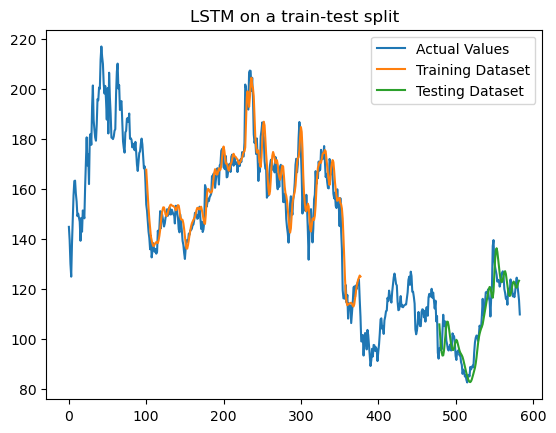

In [31]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("LSTM on a train-test split")
plt.legend(labels)
plt.show()

### Visualization of loss

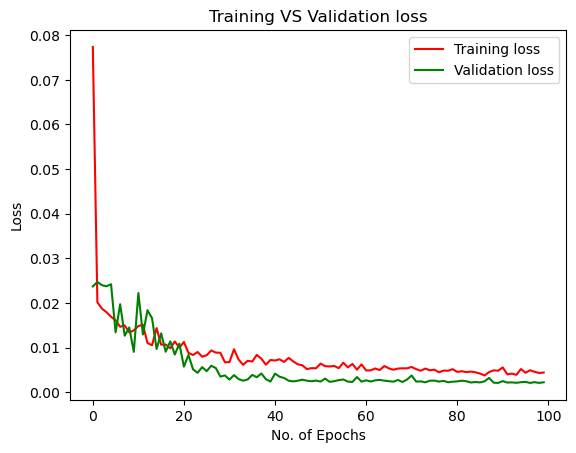

In [32]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Final Verdict via LSTM

In [33]:
# Our prediction of the stock price from last training timestamp to last tested timestamp
print("The price will move from", (str(val)[1:-1]),"to" , str(val_test)[1:-1])

The price will move from 124.85897 to 123.18366


## <font color=red>**The GRU model**</font>

### Modules and Libraries - GRU

In [34]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Preprocessing the Dataset

In [35]:
df1 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))  

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

### Train Test Split

In [36]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size

train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Layers in the GRU Model

In [37]:
# The GRU architecture
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

### Compiling, Fitting and Saving

In [38]:
optimizer = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test, y_test))

model.save('Final_model_gru.h5')

Epoch 1/100
18/18 - 9s - loss: 0.0516 - val_loss: 0.0089 - 9s/epoch - 473ms/step
Epoch 2/100
18/18 - 2s - loss: 0.0175 - val_loss: 0.0131 - 2s/epoch - 115ms/step
Epoch 3/100
18/18 - 2s - loss: 0.0113 - val_loss: 0.0115 - 2s/epoch - 113ms/step
Epoch 4/100
18/18 - 2s - loss: 0.0131 - val_loss: 0.0130 - 2s/epoch - 117ms/step
Epoch 5/100
18/18 - 2s - loss: 0.0101 - val_loss: 0.0067 - 2s/epoch - 121ms/step
Epoch 6/100
18/18 - 2s - loss: 0.0096 - val_loss: 0.0047 - 2s/epoch - 114ms/step
Epoch 7/100
18/18 - 2s - loss: 0.0093 - val_loss: 0.0047 - 2s/epoch - 122ms/step
Epoch 8/100
18/18 - 2s - loss: 0.0076 - val_loss: 0.0023 - 2s/epoch - 128ms/step
Epoch 9/100
18/18 - 2s - loss: 0.0080 - val_loss: 0.0022 - 2s/epoch - 123ms/step
Epoch 10/100
18/18 - 2s - loss: 0.0082 - val_loss: 0.0035 - 2s/epoch - 130ms/step
Epoch 11/100
18/18 - 2s - loss: 0.0078 - val_loss: 0.0024 - 2s/epoch - 126ms/step
Epoch 12/100
18/18 - 2s - loss: 0.0086 - val_loss: 0.0019 - 2s/epoch - 127ms/step
Epoch 13/100
18/18 - 2s -

### Predicting and reverse transforming

In [39]:
train_predict=model.predict(X_train)

train_predict = scaler.inverse_transform(train_predict)
array_length = len(train_predict)
val = train_predict[array_length - 1]

test_predict=model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
array_length = len(test_predict)
val_test = test_predict[array_length - 1]

4/4 [==============================] - 0s 29ms/step


### Performance Analysis

In [40]:
train_mse = math.sqrt(mean_squared_error(y_train,train_predict))
print("Root Mean Square Error while using GRU on training data : ", train_mse)
test_mse = math.sqrt(mean_squared_error(y_test,test_predict))
print("Root Mean Square Error while using GRU on testing data : ", test_mse)

Root Mean Square Error while using GRU on training data :  159.8869985548545
Root Mean Square Error while using GRU on testing data :  108.68827711629324


### Visualization of Predictions

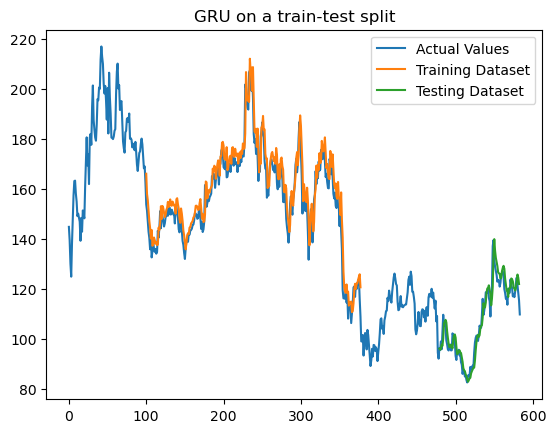

In [41]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("GRU on a train-test split")
plt.legend(labels)
plt.show()

### Visualization of loss

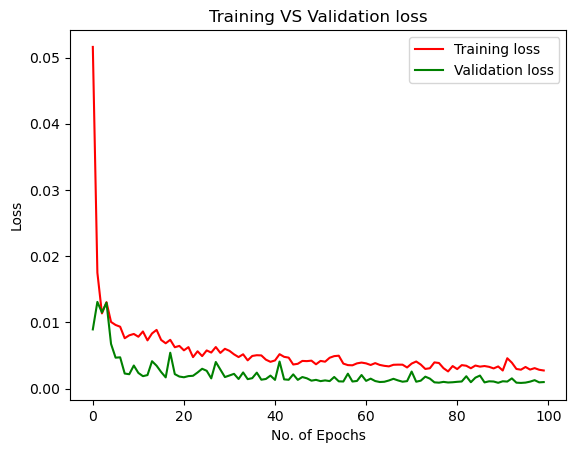

In [42]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Final Verdict via GRU

In [43]:
# Our prediction of the stock price from last training timestamp to last tested timestamp
print("The price will move from", (str(val)[1:-1]),"to" , str(val_test)[1:-1])

The price will move from 120.55197 to 121.864555


## <font color=red>**The Bidirectional LSTM model**</font>

### Modules and Libraries - Bidirectional LSTM

In [44]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, LSTM
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Preprocessing the Dataset

In [45]:
df1 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))  

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

### Train Test Split

In [46]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size

train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Layers in the Bidirectional LSTM Model

In [47]:
# The Bidirectional LSTM architecture
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=20))
model.add(Dropout(0.2))

model.add(Dense(units=1))

### Compiling, Fitting and Saving

In [48]:
optimizer = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, batch_size = 16, verbose = 2, validation_data = (X_test,y_test))

model.save('Final_model_bdLSTM.h5')

Epoch 1/100
18/18 - 8s - loss: 0.0600 - val_loss: 0.0056 - 8s/epoch - 469ms/step
Epoch 2/100
18/18 - 1s - loss: 0.0215 - val_loss: 0.0073 - 1s/epoch - 82ms/step
Epoch 3/100
18/18 - 1s - loss: 0.0157 - val_loss: 0.0054 - 1s/epoch - 81ms/step
Epoch 4/100
18/18 - 1s - loss: 0.0180 - val_loss: 0.0045 - 1s/epoch - 83ms/step
Epoch 5/100
18/18 - 1s - loss: 0.0137 - val_loss: 0.0046 - 1s/epoch - 82ms/step
Epoch 6/100
18/18 - 2s - loss: 0.0141 - val_loss: 0.0034 - 2s/epoch - 86ms/step
Epoch 7/100
18/18 - 2s - loss: 0.0110 - val_loss: 0.0053 - 2s/epoch - 90ms/step
Epoch 8/100
18/18 - 2s - loss: 0.0119 - val_loss: 0.0024 - 2s/epoch - 88ms/step
Epoch 9/100
18/18 - 2s - loss: 0.0100 - val_loss: 0.0042 - 2s/epoch - 90ms/step
Epoch 10/100
18/18 - 2s - loss: 0.0089 - val_loss: 0.0035 - 2s/epoch - 90ms/step
Epoch 11/100
18/18 - 2s - loss: 0.0094 - val_loss: 0.0019 - 2s/epoch - 91ms/step
Epoch 12/100
18/18 - 2s - loss: 0.0113 - val_loss: 0.0028 - 2s/epoch - 88ms/step
Epoch 13/100
18/18 - 2s - loss: 0.00

### Predicting and reverse transforming

In [49]:
train_predict=model.predict(X_train)

train_predict = scaler.inverse_transform(train_predict)
array_length = len(train_predict)
val = train_predict[array_length - 1]

test_predict=model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
array_length = len(test_predict)
val_test = test_predict[array_length - 1]

4/4 [==============================] - 0s 27ms/step


### Performance Analysis

In [50]:
train_mse = math.sqrt(mean_squared_error(y_train,train_predict))
print("Root Mean Square Error while using Bidirectional LSTM on training data : ", train_mse)
test_mse = math.sqrt(mean_squared_error(y_test,test_predict))
print("Root Mean Square Error while using Bidirectional LSTM on testing data : ", test_mse)

Root Mean Square Error while using Bidirectional LSTM on training data :  159.57615333484347
Root Mean Square Error while using Bidirectional LSTM on testing data :  104.14820373645632


### Visualization of Predictions

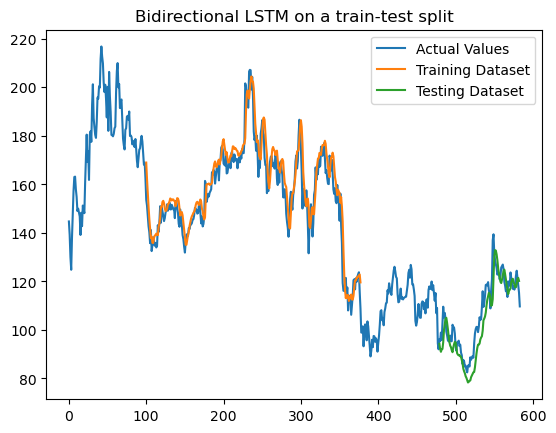

In [51]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("Bidirectional LSTM on a train-test split")
plt.legend(labels)
plt.show()

### Visualization of loss

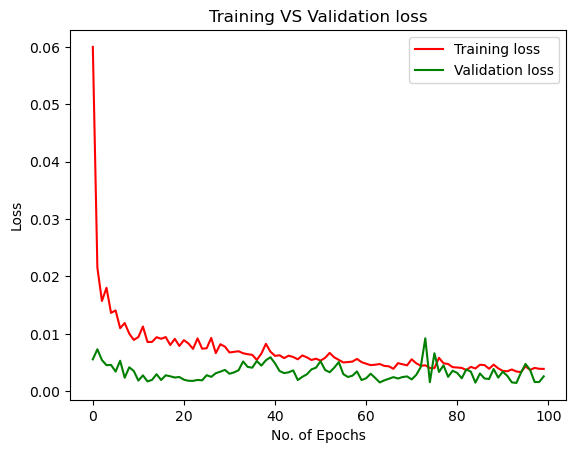

In [52]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Final Verdict via Bidirectional LSTM

In [53]:
# Our prediction of the stock price from last training timestamp to last tested timestamp
print("The price will move from", (str(val)[1:-1]),"to" , str(val_test)[1:-1])

The price will move from 119.59452 to 120.18428


## <font color=red>**The Bidirectional GRU model**</font>

### Modules and Libraries - Bidirectional GRU

In [54]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, GRU
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Preprocessing the Dataset

In [55]:
df1 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))  

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

### Train Test Split

In [56]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size

train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Layers in the Bidirectional GRU Model

In [57]:
# The Bidirectional GRU architecture
model = Sequential()
model.add(Bidirectional(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh')))

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

### Compiling, Fitting and Saving

In [58]:
optimizer = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_test, y_test))

model.save('Final_model_bdGRU.h5')

Epoch 1/100
9/9 - 11s - loss: 0.0805 - val_loss: 0.0136 - 11s/epoch - 1s/step
Epoch 2/100
9/9 - 1s - loss: 0.0193 - val_loss: 0.0144 - 1s/epoch - 145ms/step
Epoch 3/100
9/9 - 1s - loss: 0.0138 - val_loss: 0.0124 - 1s/epoch - 149ms/step
Epoch 4/100
9/9 - 1s - loss: 0.0106 - val_loss: 0.0126 - 1s/epoch - 144ms/step
Epoch 5/100
9/9 - 1s - loss: 0.0114 - val_loss: 0.0076 - 1s/epoch - 150ms/step
Epoch 6/100
9/9 - 1s - loss: 0.0100 - val_loss: 0.0087 - 1s/epoch - 157ms/step
Epoch 7/100
9/9 - 1s - loss: 0.0092 - val_loss: 0.0064 - 1s/epoch - 166ms/step
Epoch 8/100
9/9 - 1s - loss: 0.0094 - val_loss: 0.0030 - 1s/epoch - 167ms/step
Epoch 9/100
9/9 - 1s - loss: 0.0092 - val_loss: 0.0027 - 1s/epoch - 163ms/step
Epoch 10/100
9/9 - 1s - loss: 0.0092 - val_loss: 0.0029 - 1s/epoch - 151ms/step
Epoch 11/100
9/9 - 1s - loss: 0.0078 - val_loss: 0.0022 - 1s/epoch - 161ms/step
Epoch 12/100
9/9 - 1s - loss: 0.0088 - val_loss: 0.0019 - 1s/epoch - 163ms/step
Epoch 13/100
9/9 - 1s - loss: 0.0081 - val_loss: 0

### Predicting and reverse transforming

In [59]:
train_predict=model.predict(X_train)

train_predict = scaler.inverse_transform(train_predict)
array_length = len(train_predict)
val = train_predict[array_length - 1]

test_predict=model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
array_length = len(test_predict)
val_test = test_predict[array_length - 1]

4/4 [==============================] - 0s 33ms/step


### Performance Analysis

In [60]:
train_mse = math.sqrt(mean_squared_error(y_train,train_predict))
print("Root Mean Square Error while using Bidirectional GRU on training data : ", train_mse)
test_mse = math.sqrt(mean_squared_error(y_test,test_predict))
print("Root Mean Square Error while using Bidirectional GRU on testing data : ", test_mse)

Root Mean Square Error while using Bidirectional GRU on training data :  156.1252275153833
Root Mean Square Error while using Bidirectional GRU on testing data :  106.10787859951462


### Visualization of Predictions

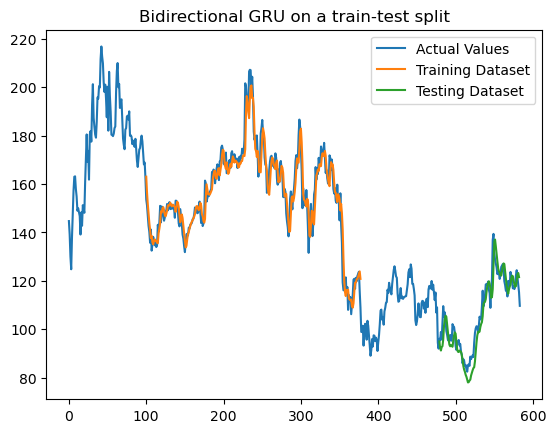

In [61]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("Bidirectional GRU on a train-test split")
plt.legend(labels)
plt.show()

### Visualization of loss

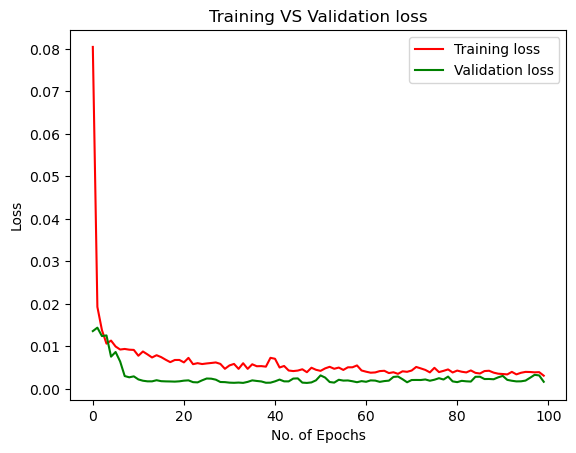

In [62]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Final Verdict via Bidirectional GRU

In [63]:
# Our prediction of the stock price from last training timestamp to last tested timestamp
print("The price will move from", (str(val)[1:-1]),"to" , str(val_test)[1:-1])

The price will move from 120.82703 to 121.54718
